# Milestone 2 - First Model

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scripts import *

### I. Data Prepration

In [2]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader(data_path)


In [3]:
num_classes = len(os.listdir(data_path))
num_classes

FileNotFoundError: [Errno 2] No such file or directory: './DLCV_SS25_Dataset'

In [ ]:
len(images)

2351

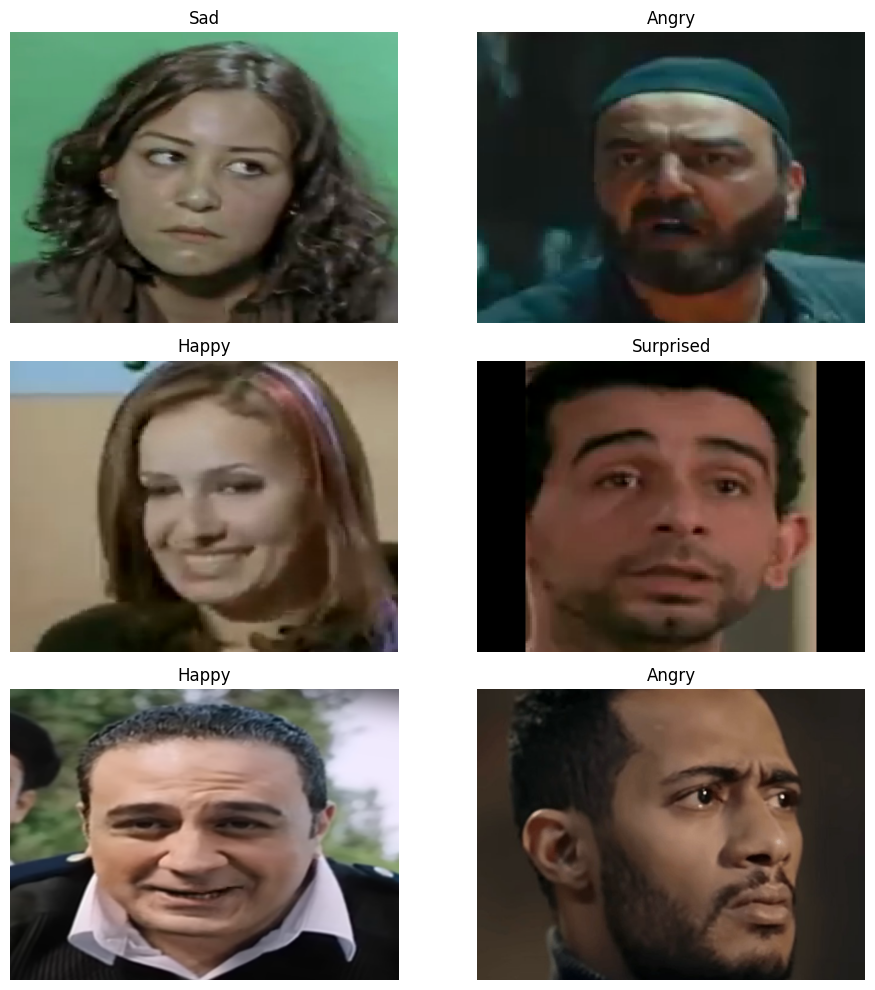

In [ ]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator((images, labels))
index_to_label = {v: k for k, v in label_to_index.items()}

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645, 512, 512, 3),
 (1645,),
 (470, 512, 512, 3),
 (470,),
 (236, 512, 512, 3),
 (236,))

In [4]:
draw_barchart_labels(train_labels, label_to_index)

NameError: name 'train_labels' is not defined

In [5]:
draw_barchart_labels(val_labels, label_to_index)

NameError: name 'val_labels' is not defined

In [6]:
draw_barchart_labels(test_labels, label_to_index)

NameError: name 'test_labels' is not defined

### II.First Model

In [ ]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

In [ ]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(train_data[0])
output.shape

(510, 510, 4)

In [ ]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters)

output = conv_layer.forward(train_data[0])
output.shape

(510, 510, 5)

In [ ]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(train_data[0])
output.shape

(256, 256, 3)

In [ ]:
first_model = FirstModel()
first_model.fit(train_data[:20], num_clusters=5)

100%|██████████| 20/20 [03:19<00:00,  9.97s/it]

Extracted features shape: (20, 128)


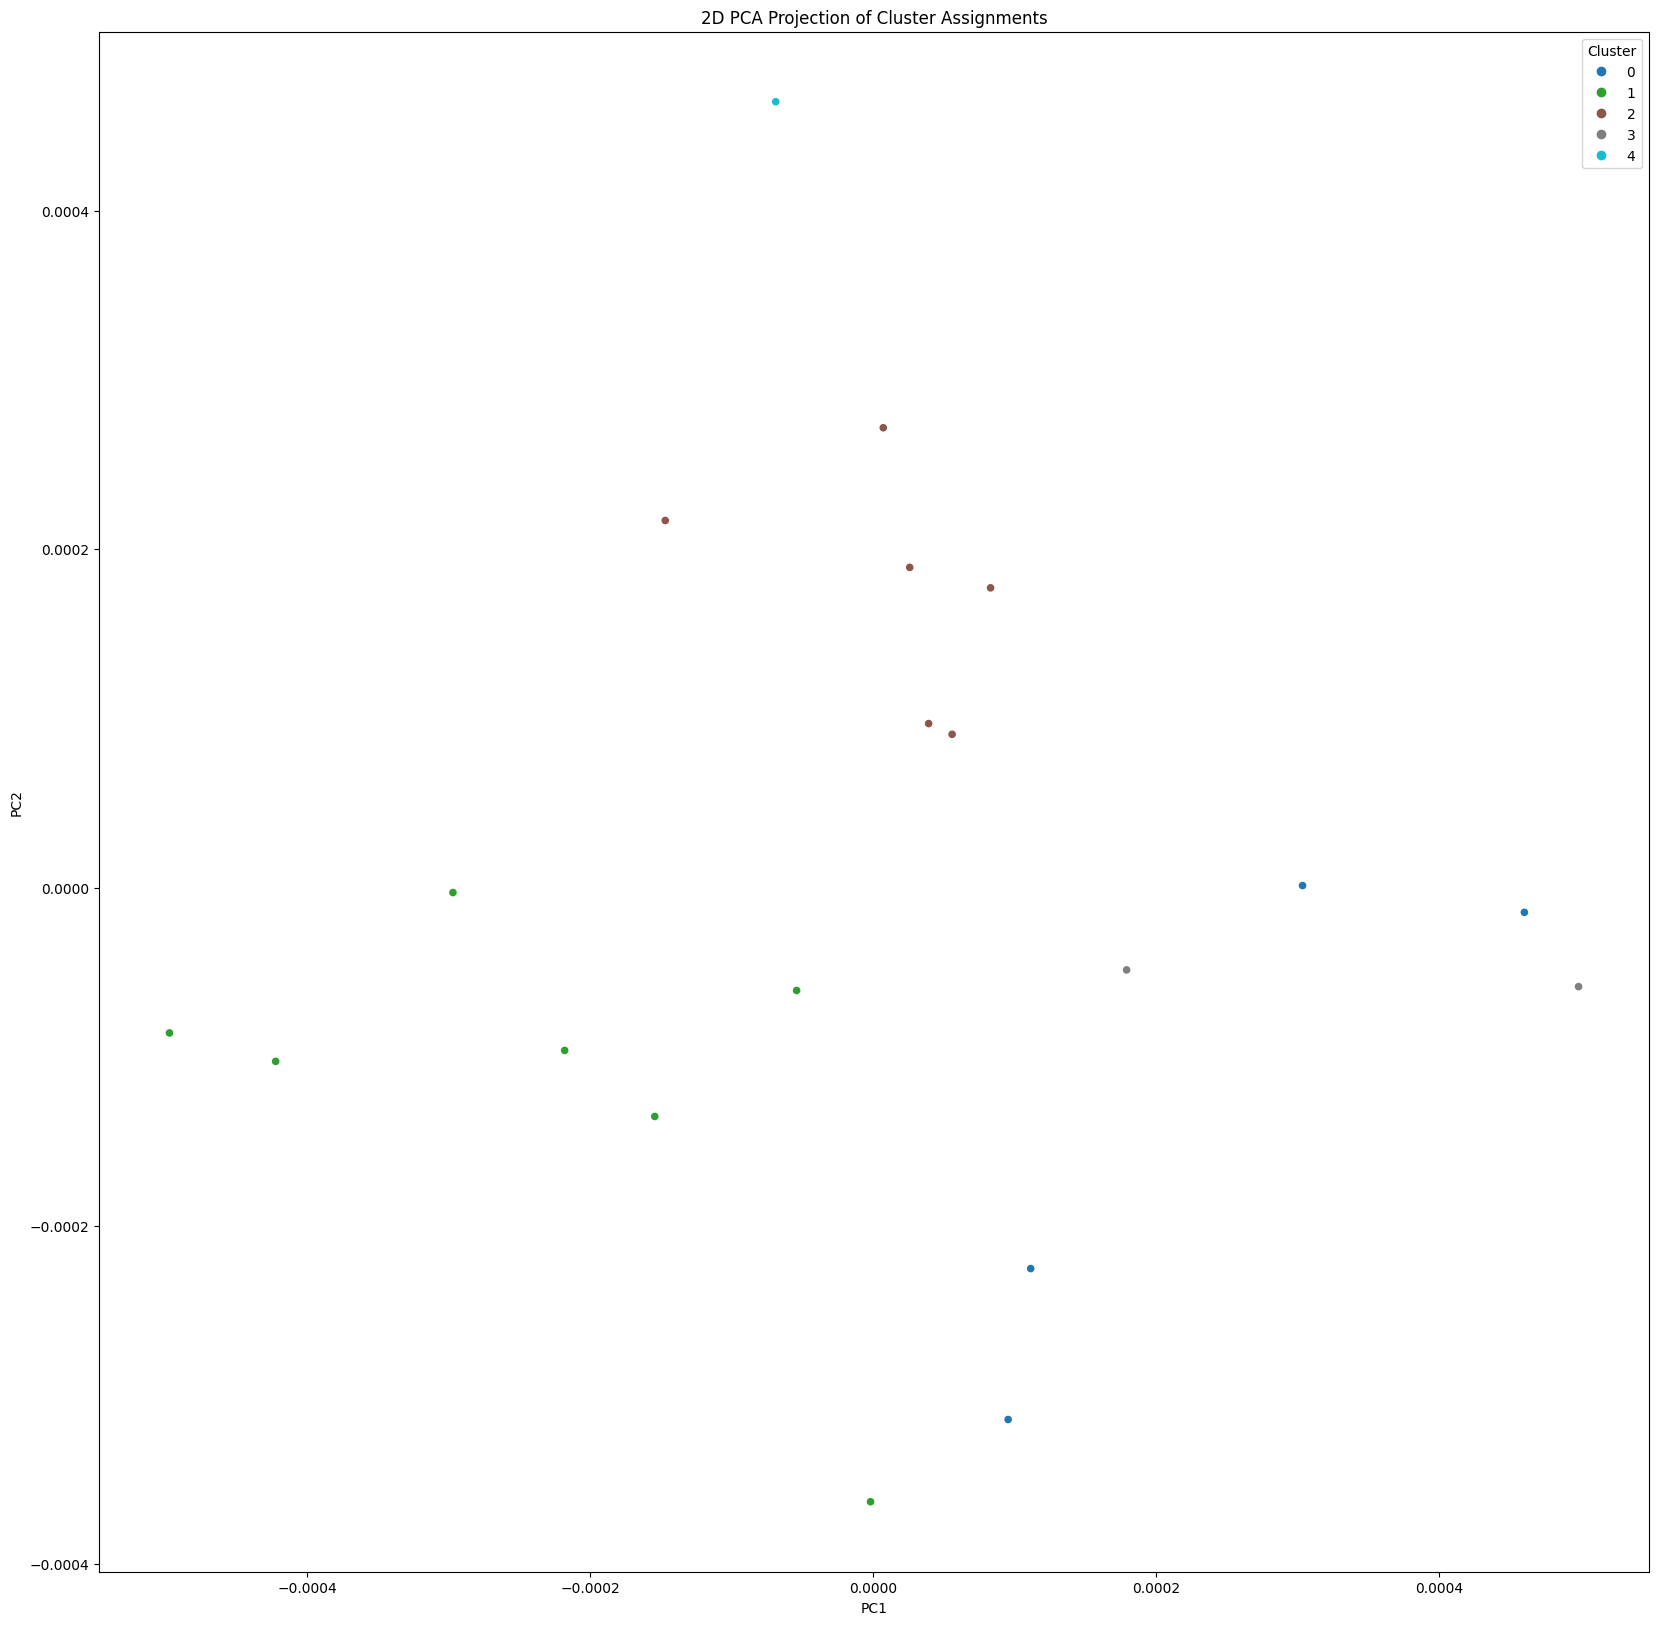

In [ ]:
plot_feature_scatter(first_model.features,
                     first_model.kmeans.labels_, n_components=2)

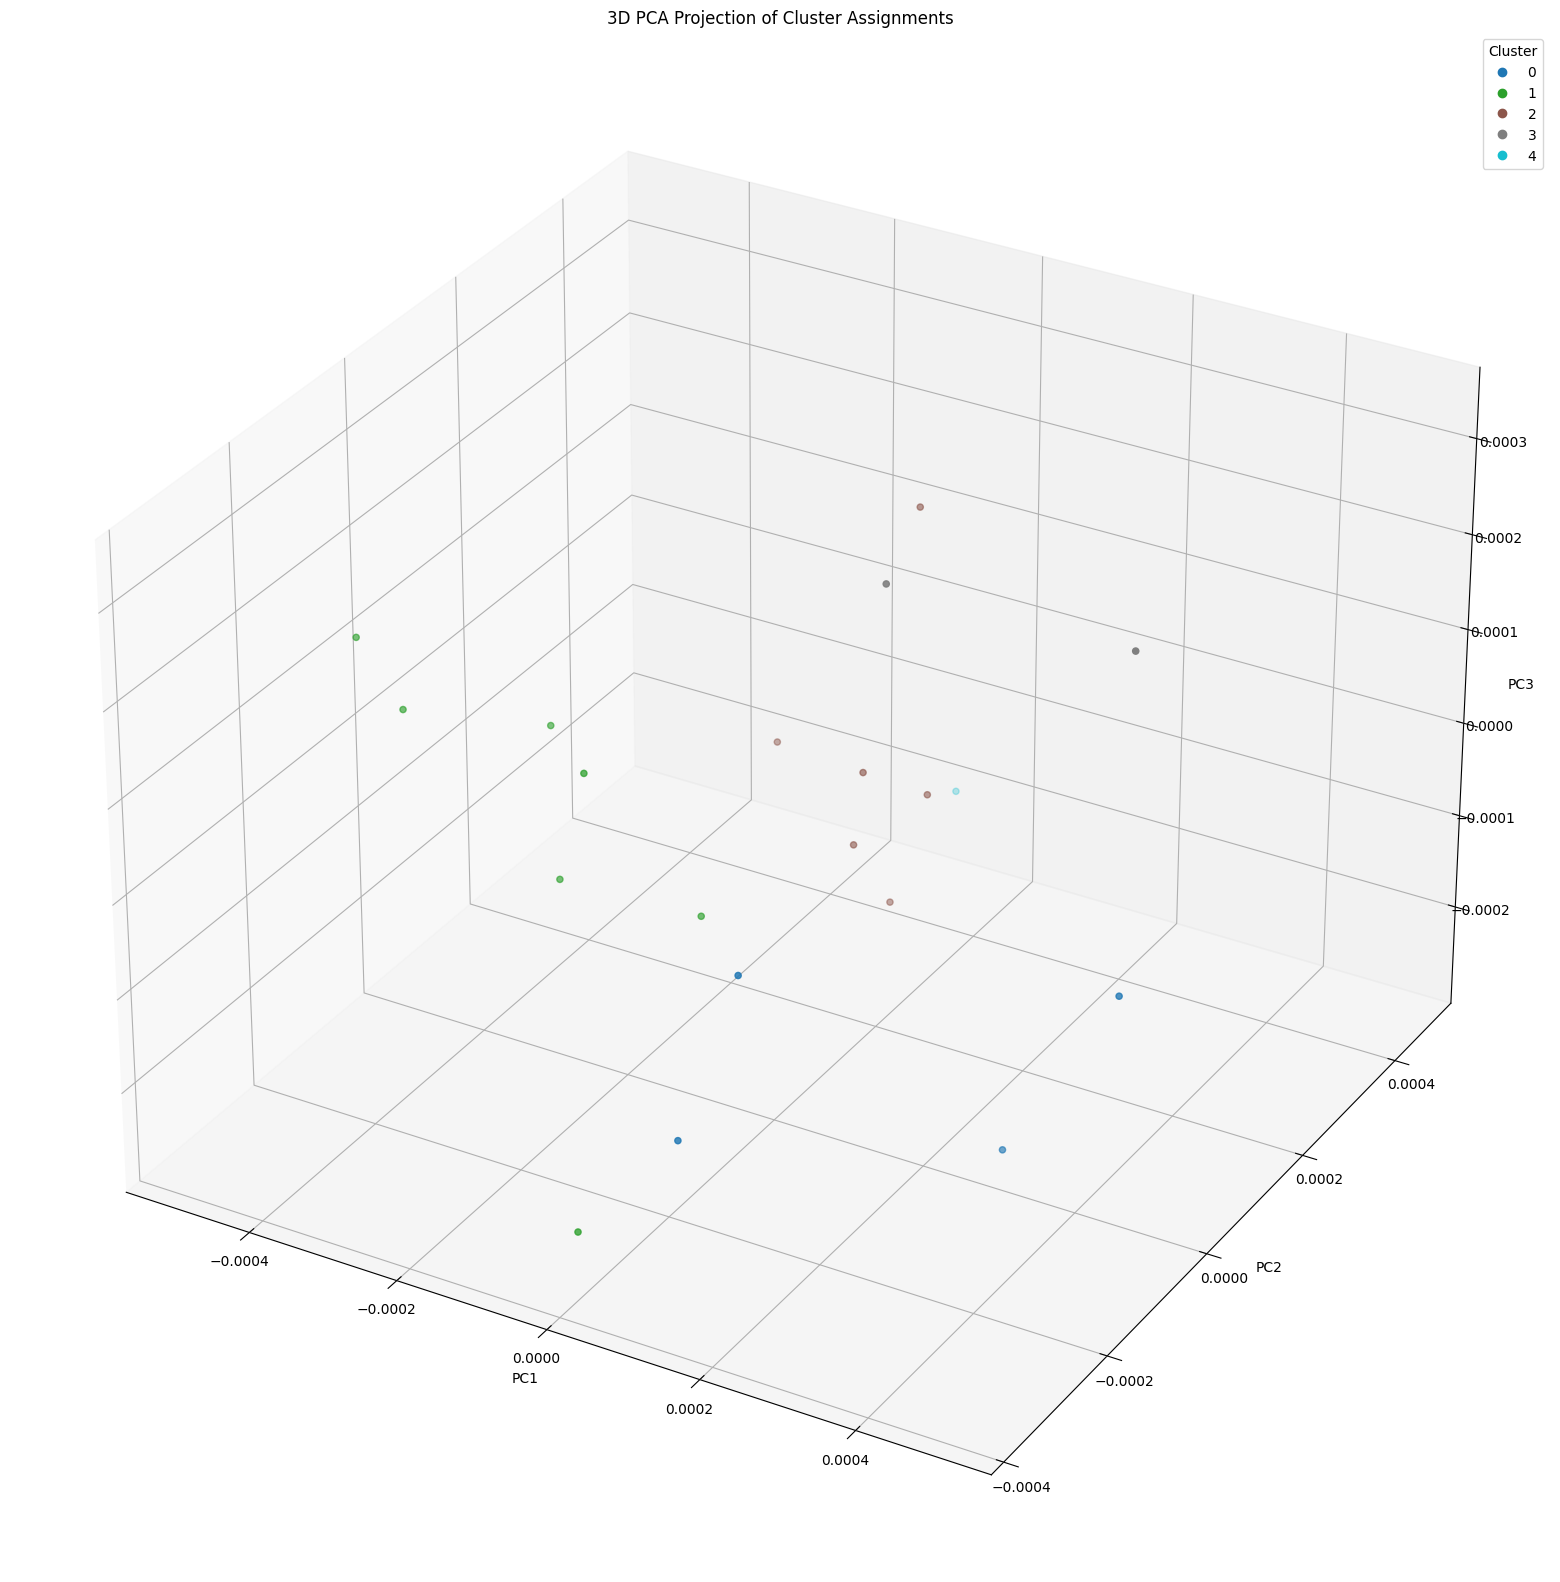

In [ ]:
plot_feature_scatter(first_model.features,
                     first_model.kmeans.labels_, n_components=3)